# Homework Set 3

**Author**: Chase Coleman

**NYU ID**: N10827183

**Date**: 12 February 2016

## Question

The file `company_list.csv` in the `hw_set3` directory contains a list of companies, including ticker symbol, name, and market capitalization. Write a program that obtains the daily percentage change in the share price of each of these companies by sending a query to the Yahoo finance API.

See

[http://www.jarloo.com/yahoo_finance/](http://www.jarloo.com/yahoo_finance/)

For some hints on how to do that.

Generate a scatter plot of absolute value of percentage change against market capitalization. Are lower cap stocks more volatile according to this measure?

The rules of the game are that only these import statements are legal:

```python
import matplotlib.pyplot as plt
import requests
import re
```

Also, the percentage change in prices must be obtained live, when the program is run (assuming a working Internet connection).

Submit your work as a Jupyter notebook that contains the program and the resulting figure. You are free to collaborate but should submit your own work.

## Solution

We begin by using the permitted import statements

In [1]:
import matplotlib.pyplot as plt
import requests as r
import re

%matplotlib inline

The first thing we will do is write a function to put all of the company tickers from the file `company_list.csv` into a single list.

In [2]:
def retrieve_company_tickers(fname, tckrloc=0):
    """
    This function retrieves all company tickers from
    a file. It requires that company ticker is in the
    first column of the file
    
    Parameters
    ----------
    fname : string
        The name of file (and relative path)
    tckrloc : int (default=0)
        The column number in which the ticker
        name is stored
        
    Returns
    -------
    tickerlist : list(strings)
        A list of all ticker names
    """
    tickerlist = []
    
    with open(fname) as f:
        for line in f:
            # No quotes
            line_nq = line.replace('"', '')
            
            # Split line at commas
            splitline = line_nq.split(',')
            
            # Company ticker
            cticker = splitline[tckrloc]
            
            # Add ticker to list if it isn't 'Symbol'
            if cticker not in ("symbol", "Symbol"):
                tickerlist.append(cticker)
            
    return tickerlist

Our next step will be to write a function which will use the Yahoo API and return several things for a given ticker(s):

* Symbol (`s`): This is the symbol for the stock ticker(which we use as an input, but return it anyways)
* Opening price (`o`): Price at which the stock opened for the day
* Previous closing price (`p`): Price at which the stock closed on previous day
* Change Percent Realtime(`k2`): This is the realtime percent change in price for the day
* Market Capitalization (`j1`): This is firm's market capitalization


In [3]:
def retrieve_data(ticker):
    """
    Uses the given ticker to retrieve symbol, percentage
    change in price (from opening price), and market
    capitalization from Yahoo finance
    
    Parameters
    ----------
    ticker : String
        This is a string of companies that you would like
        query the data for. Must be separated by `+`
    
    Returns
    -------
    data : Dict
        This is a dictionary where the keys are the company
        ticker and the value is a dictionary with the
        information that is retrieved from Yahoo
    """
    # Set base url (will add parameters to this afterwards)
    base_url = "http://finance.yahoo.com/d/quotes.csv"
    
    # Parameters for url
    pdict = {}
    
    # Company/Companies which we will be querying
    pdict["s"] = ticker
    
    # Want symbol/open price/previous close price
    #      % change in price/shares outstanding
    pdict["f"] = "sopk2j1j2"
    
    # Fetch data from url with given parameters
    csv = r.get(base_url, params=pdict)
    
    # Pass data to another function to get cleaned
    data = clean_data(csv)
    
    return data

def clean_data(yahoorequest):
    """
    Cleans data that comes from a Yahoo request
    for financial data
    """
    # Create storage dictionary
    outdict = {}
    
    # Elements that we pulled from Yahoo
    infokeys = ["Market Cap", "Percent Change"]
    
    # Yahoo has odd double quotes everywhere so
    # strip all those guys out and split into list
    lines = yahoorequest.text.replace('"', '').split('\n')[:-1]
    
    # ... To hell with "N/A" and "N/A\n
    argh = ('N/A', 'N/A\n')
    
    for line in lines:
        currline = line.split(',')
        
        # Pull out all info on the line
        s, o, p, k2, j1, j2 = currline
        
        # First try to use what Yahoo has for market cap
        if j1 not in argh:
            mktcap = convert_market_cap_2_float(j1)
        # Next try and compute Market Cap directly
        elif (j2 not in argh) and (p not in argh):
            mktcap = float(p)*float(j2)
        else:
            continue
        
        # Make sure not inf percentage change
        if ('inf' not in (k2)) and (k2 not in argh):
            perchg = float(k2.strip('+-%'))
        else:
            continue

        outdict[s] = dict(zip(infokeys, [mktcap, perchg]))
        
    return outdict

def convert_market_cap_2_float(mc):
    """
    Converts Yahoo's market caps from strings
    to float using M and B
    """
    if mc[-1] in ('M', 'm'):
        mcout = float(mc[:-1]) * 1e6
    elif mc[-1] in ('B', 'b'):
        mcout = float(mc[:-1]) * 1e9
    else:
        mcout = float(mc)

    return mcout

Yahoo restricts query's to 200 company names. We will write a function that takes our entire list of company tickers and breaks it up into smaller lists that Yahoo allows us to query with.

In [4]:
def retrieve_all_data(tickers):
    """
    Takes a list of ticker names and query's
    Yahoo's financial data base for the
    information required for homework 3
    """
    # Number of tickers we have
    ntick = len(tickers)
    success = []
    out = {}
    
    # Various parameters for iteration
    start = 0
    step = 175
    end = start + step
    
    while end < ntick:
        # Join tickers by "+" and then get current data
        curr_tickers = '+'.join(tickers[start:end])
        littledict = retrieve_data(curr_tickers)
        
        # Update our final dictionary
        out.update(littledict)
        
        # Update start and end
        start = start + step
        end = min(end+step, ntick)
    
    # Create a list of all successful outcomes
    success = list(out.keys())

    return success, out

In [5]:
# Enter our file path and name
fpath = "../../quantecon_nyu_2016/homework_assignments/hw_set3/"
fname = "company_list.csv"

# Get all of our tickers
alltickers = retrieve_company_tickers(fpath+fname)
success, data = retrieve_all_data(alltickers)

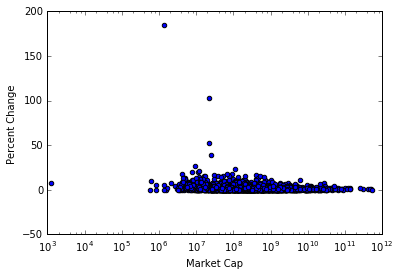

In [6]:
def gen_plot(success, data):
    """
    Plots market cap versus percentage change in price
    """
    # Get market cap data
    gmc = lambda x: data[x]["Market Cap"]
    marketcap = list(map(gmc, success))
    
    # Get percentage change data
    gpc = lambda x: data[x]["Percent Change"]
    perchange = list(map(gpc, success))
    
    fig, ax = plt.subplots()
    
    # Change scale to log log
    ax.set_xscale("log")
#     ax.set_yscale("log")
    
    ax.scatter(marketcap, perchange)
    
    
    ax.set_xlabel("Market Cap")
    ax.set_ylabel("Percent Change")
    
    return fig

fig = gen_plot(success, data)